
**Install requirements**

In [1]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'
!pip install -U pillow
!pip install wandb

ERROR: Invalid requirement: "'torch==1.3.1'"

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: "'torchvision==0.5.0'"

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: "'Pillow-SIMD'"

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: "'tqdm'"

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 2.5/2.5 MB 1.3 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.3.0
    Uninstalling Pillow-9.3.0:
      Successfully uninstalled Pillow-9.3.0



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


**Import libraries**

In [4]:
import numpy as np
import matplotlib.pyplot as plt 
from statistics import mean 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
import torchvision
from torch.autograd import Variable
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torchvision import transforms
from torchvision.models import alexnet, vgg16, resnet18, resnet50
from PIL import Image
from tqdm import tqdm
import wandb

**Set Arguments**

In [17]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 100    #num classes of CIFAR100

BATCH_SIZE = 128     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.1      # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 0.0001  # Regularization, you can keep this at the default

NUM_EPOCHS = 160   # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20    # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 1         # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 100

**Define Data Preprocessing**

In [6]:
PRE_TRAINED = False     # set to True to load the pre-trained ImageNet

NETWORK_TYPE = "resnet20"       #define which network we will use: alexnet, vgg, resnet18, resnet20...

FREEZING = "no_freezing"        # define which layers of the network will be kept frozen
                                # None : train the whole network
                                # "CONV" : train only the FC-layers
                                # "FC" : train only the conv-layers

AUG_PROB = 0.5   # the probability with witch each image is transformed at training time during each epoch
AUG_TYPE = "RC-RHF"         # define the type of augmentation pipeline 
                            # None for no data augmentation
                            # "CS-HF" for contrast + saturation + horizontal flip
                            # "H-RP" for hue + random perspective
                            # "B-GS-R" for brightness + grayscale + rotation
                            # "RC-RHF" random crop + random horizontal flip => for the project

**Trasformations**

In [7]:
from torch.utils.data import random_split

#(0.5071, 0.4867, 0.4408) #mean cifar100
#(0.4914, 0.4822, 0.4465) #mean cifar10

#(0.2675, 0.2565, 0.2761) #std cifar100
#(0.2023, 0.1994, 0.2010) #std cifar10

if PRE_TRAINED:
  normalizer = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) #pretrained on imagenet
else:
  normalizer = transforms.Normalize(mean = (0.5071, 0.4867, 0.4408), std= (0.2675, 0.2565, 0.2761)) #mean and std of cifar100

# Define transforms for training phase
train_transform = transforms.Compose([transforms.ToTensor()])

# Define transforms for the evaluation phase
test_transform = transforms.Compose([transforms.ToTensor()])

# Other types of transformations
bright_t = transforms.ColorJitter(brightness=[1,2])
contrast_t = transforms.ColorJitter(contrast = [2,5])
saturation_t = transforms.ColorJitter(saturation = [1,3])
hue_t = transforms.ColorJitter(hue = 0.2)
gs_t = transforms.Grayscale(3)
rp_t = transforms.RandomPerspective(p = 1, distortion_scale = 0.5)
rot_t = transforms.RandomRotation(degrees = 90)
rand_crop = transforms.RandomCrop(32, padding = 4)
hflip_t = transforms.RandomHorizontalFlip(p = 1)

aug_transformations = {
    "CS-HF": transforms.Compose([contrast_t, saturation_t, hflip_t]),
    "H-RP": transforms.Compose([hue_t, rp_t]),
    "B-GS-R": transforms.Compose([bright_t, gs_t, rot_t]),
    "RC-RHF": transforms.Compose([rand_crop, hflip_t])
    }

if AUG_TYPE is not None:
  aug_transformation = aug_transformations[AUG_TYPE]
  aug_pipeline = transforms.Compose([ 
                                      transforms.ToPILImage(),
                                      transforms.RandomApply([aug_transformation], p = AUG_PROB),
                                      transforms.ToTensor(),
                                      normalizer
                                     ])
else:
  aug_pipeline = normalizer


**Define Training set, validation set and testing**



In [8]:

VAL_SIZE = 5000

#load training and testing
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=train_transform)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True,transform=test_transform)

# print some statistics
classes = trainset.classes
class_count = {}
for _, index in trainset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
print(class_count)
print(f"classi totali: {len(class_count)}")


#retrive training and validation from training data
train_size = len(trainset) - VAL_SIZE
trainset, validset = random_split(trainset, [train_size, VAL_SIZE])


#load dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2, drop_last=True)

validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2, drop_last=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2, drop_last=True)

# Check dataset sizes
print('Train Dataset: {}'.format(len(trainset)))
print('Valid Dataset: {}'.format(len(validset)))
print('Test Dataset: {}'.format(len(testset)))


100%|██████████| 169001437/169001437 [01:38<00:00, 1721423.07it/s]


Extracting ./data\cifar-100-python.tar.gz to ./data
Files already downloaded and verified
{'cattle': 500, 'dinosaur': 500, 'apple': 500, 'boy': 500, 'aquarium_fish': 500, 'telephone': 500, 'train': 500, 'cup': 500, 'cloud': 500, 'elephant': 500, 'keyboard': 500, 'willow_tree': 500, 'sunflower': 500, 'castle': 500, 'sea': 500, 'bicycle': 500, 'wolf': 500, 'squirrel': 500, 'shrew': 500, 'pine_tree': 500, 'rose': 500, 'television': 500, 'table': 500, 'possum': 500, 'oak_tree': 500, 'leopard': 500, 'maple_tree': 500, 'rabbit': 500, 'chimpanzee': 500, 'clock': 500, 'streetcar': 500, 'cockroach': 500, 'snake': 500, 'lobster': 500, 'mountain': 500, 'palm_tree': 500, 'skyscraper': 500, 'tractor': 500, 'shark': 500, 'butterfly': 500, 'bottle': 500, 'bee': 500, 'chair': 500, 'woman': 500, 'hamster': 500, 'otter': 500, 'seal': 500, 'lion': 500, 'mushroom': 500, 'girl': 500, 'sweet_pepper': 500, 'forest': 500, 'crocodile': 500, 'orange': 500, 'tulip': 500, 'mouse': 500, 'camel': 500, 'caterpillar'

**Show immages and classes of the dataset**

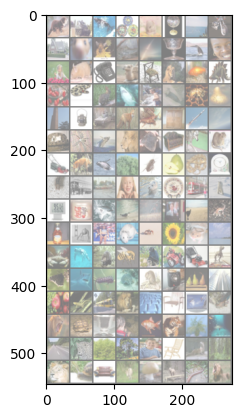

otter tank  whale plate mouse cup   sea   motorcycle house hamster bee   crocodile rocket cup   whale woman girl  hamster telephone camel chair lion  aquarium_fish dinosaur pear  snake rabbit shark boy   otter bee   pear  skyscraper lamp  tank  fox   lobster wardrobe rocket cloud couch spider whale lion  flatfish couch wolf  mouse lawn_mower fox   whale willow_tree cockroach pear  snake clock caterpillar streetcar streetcar girl  seal  plate streetcar bear  clock can   shark seal  forest television plain lizard bottle camel woman possum crab  sunflower hamster sea   crab  turtle beaver bee   chimpanzee motorcycle lawn_mower dinosaur butterfly shark caterpillar ray   beaver telephone pear  skyscraper apple lizard streetcar lion  keyboard chair television tiger lion  turtle cup   baby  aquarium_fish tiger palm_tree shark road  leopard willow_tree pine_tree boy   chair otter forest lion  snail couch cattle mushroom beaver worm  lion 


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))


**Build resNet20**

In [10]:
TYPE_OF_NORM = "group" #batch or group
NUM_GROUP = 8   #2,4,8
# GroupNorm takes number of groups to divide the channels in and the number of channels to expect in the input. 

def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)
        
#Define ResNet20

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
    
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        if TYPE_OF_NORM == 'batch':
          self.bn1 = nn.BatchNorm2d(planes)
          self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
          self.bn2 = nn.BatchNorm2d(planes)
        else:
          self.gn1 = nn.GroupNorm(NUM_GROUP, planes)
          self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
          self.gn2 = nn.GroupNorm(NUM_GROUP, planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
          if TYPE_OF_NORM == 'batch':
            self.shortcut = nn.Sequential(
                  nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                  nn.BatchNorm2d(self.expansion * planes) )
          else:
            self.shortcut = nn.Sequential(
                  nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                  nn.GroupNorm(NUM_GROUP, self.expansion * planes)  )
          
        self.relu = nn.ReLU()
        self.stride = stride

    def forward(self, x):
        out = self.conv1(x)
        if TYPE_OF_NORM == "batch":
          out = self.bn1(out)
        else:
          out = self.gn1(out)

        out = self.relu(out)
        out = self.conv2(out)

        if TYPE_OF_NORM == "batch":
          out = self.bn2(out)
        else:
          out = self.gn2(out)
    
        out += self.shortcut(x)
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        
        if TYPE_OF_NORM == 'batch':
          self.bn1 = nn.BatchNorm2d(16)
        else:
          self.gn1 = nn.GroupNorm(NUM_GROUP, 16)
        self.relu = nn.ReLU()

        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        if TYPE_OF_NORM == "batch":
          out = self.bn1(out)
        else:
          out = self.gn1(out)
        out = self.relu(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = torch.nn.functional.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])

**Prepare Network**

In [11]:

if NETWORK_TYPE == 'alexnet':
  net = alexnet(pretrained=PRE_TRAINED) # Loading AlexNet model, if pretrained = True, returns a model pre-trained on ImageNet
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

# OTHER NETWORKS ------------------------------------------------------------------------------------------
elif NETWORK_TYPE == 'vgg':
  net = vgg16(pretrained='imagenet')
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

elif NETWORK_TYPE == 'resnet20':  
  print("resnet20")
  net = resnet20()  
  print(net) #show details of resnet20

elif NETWORK_TYPE == 'resnet18':  
  net = resnet18()  
  print(net) #show details of resnet18


resnet20
ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (gn1): GroupNorm(8, 16, eps=1e-05, affine=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (gn1): GroupNorm(8, 16, eps=1e-05, affine=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (gn2): GroupNorm(8, 16, eps=1e-05, affine=True)
      (shortcut): Sequential()
      (relu): ReLU()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (gn1): GroupNorm(8, 16, eps=1e-05, affine=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (gn2): GroupNorm(8, 16, eps=1e-05, affine=True)
      (shortcut): Sequential()
      (relu): ReLU()
    )
    (2): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_

**Prepare Training**

In [12]:
SCHEDULER_TYPE = 'cosine' #step or cosine

# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize and which one to freeze
if (FREEZING == 'no_freezing'):
  parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
elif (FREEZING == 'conv_layers'):
  parameters_to_optimize = net.classifier.parameters() # Updates only fully-connected layers (no conv)
elif (FREEZING == 'fc_layers'):
  parameters_to_optimize = net.features.parameters() # Updates only conv layers (no fc)
else :
  raise (ValueError(f"Error Freezing layers (FREEZE = {FREEZING}) \n Possible values are: 'no_freezing', 'conv_layers', 'fc_layers' "))

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
#parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
if SCHEDULER_TYPE == 'step':
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
else: 
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=0.00001)

**Validation**

In [15]:

def evaluate(net, dataloader, print_tqdm = True):
  with torch.no_grad():
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    net.train(False) # Set Network to evaluation mode
    running_corrects = 0
    iterable = tqdm(dataloader) if print_tqdm else dataloader
    losses = []
    for images, labels in iterable: 
      norm_images = []
      for image in images:
        norm_image = normalizer(image)
        norm_images.append(norm_image)
      norm_images = torch.stack(norm_images)  
      norm_images = norm_images.to(DEVICE)
      labels = labels.to(DEVICE)
      # Forward Pass
      outputs = net(norm_images)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      # Get predictions
      _, preds = torch.max(outputs.data, 1)
      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()
    # Calculate Accuracy
    accuracy = running_corrects / float(len(dataloader.dataset))

  return accuracy, mean(losses)

**Wandb configuration**

In [14]:
# start a new experiment
wandb.login()
wandb.init(project="AML3")

# capture a dictionary of hyperparameters with config
wandb.config = {"learning_rate": 0.1, "epochs": 160, "batch_size": 128}
model = resnet20()
wandb.watch(model)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s301104 (aml_federated_learning_project). Use `wandb login --relogin` to force relogin


[]

**Train**

In [18]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0

val_accuracies = []
val_losses = []
train_accuracies = []
train_losses = []

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

  # Iterate over the dataset
  for images, labels in trainloader:
    aug_images = []

    for image in images:
      aug_image = aug_pipeline(image) 
      aug_images.append(aug_image) 

    aug_images = torch.stack(aug_images)

    # Bring data over the device of choice
    aug_images = aug_images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(aug_images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  train_acc, train_loss = evaluate(net, trainloader, print_tqdm = False)
  train_accuracies.append(train_acc)
  train_losses.append(train_loss)
  
  val_acc, val_loss = evaluate(net, validloader, print_tqdm = False)
  val_accuracies.append(val_acc)
  val_losses.append(val_loss)
  d = {"train_acc": train_acc, "train_loss": train_loss, "val_acc": val_acc, "val_loss": val_loss }

  wandb.log(d)
  torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, './checkpoint2')

  # Step the scheduler
  scheduler.step() 

Starting epoch 1/160, LR = [0.1]


KeyboardInterrupt: 

In [13]:
wandb.save("model.h5")

[]

In [ ]:
model = resnet20()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

checkpoint = torch.load('./checkpoint')
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

**Show accuracy and loss graphs**

Best accuracies on the validation set:  0.284


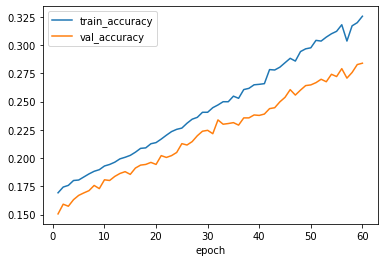

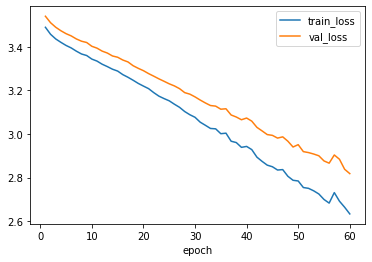

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
print("Best accuracies on the validation set: ", val_acc)

results_df = pd.DataFrame(zip(range(1,NUM_EPOCHS+1), train_accuracies, val_accuracies, train_losses, val_losses), columns = ["epoch", "train_accuracy", "val_accuracy", "train_loss", "val_loss"])
results_df.set_index("epoch")
results_df.plot(x = "epoch", y = ["train_accuracy", "val_accuracy"])
results_df.plot(x = "epoch", y = ["train_loss", "val_loss"])

**Test**

In [19]:
accuracy = evaluate(net, testloader)[0]
print('\nTest Accuracy: {}'.format(accuracy))

100%|██████████| 78/78 [00:02<00:00, 32.98it/s]


Test Accuracy: 0.3005
